Remainder:

In the last notebook we got the best RandomForestClassifier model with this parameters:
{'model__max_depth': 8,
 'model__n_estimators': 49,
 'preprocessor__numerical_transformer__imputer__n_neighbors': 1}
 
When I say the best I mean if we consider in the **scoring method just accuracy**, so with the previous model we got: 0.795 .. nearly 80% accuracy in their predictions.

But when we are dealing with classifier we can use differents scorings. Not all error are equally important. when we incorrectly classified and operation we can do two types of mistakes; incorrecly saying is positive or incorrecly saying is negative. We say we **False positive** and **False negative** respectively.

**False positive**: we predict the data is positive but it was negative instead.
**False negative**: we predict the data is negative but it was positive instead.
There a lot of materials in the internet, so we will not delve into it. But we are going to tune machine learning models giving this errors' types.

In [1]:
# import 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# This Libraries were use in the other example because we needed to predict a numerical value
# now we are predicting a category

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# New libraries that we haven't use yet!
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# These functions are going to be use in the next notebook
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score



In [21]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
pio.renderers.default = "svg"

import os

In [3]:
# This data you can find here: https://www.kaggle.com/competitions/spaceship-titanic/data
X_full = pd.read_csv('train.csv', index_col='PassengerId')

# This is the real test, but we are going to use a test created by us to use easily ROC-AUC

# X_test_full = pd.read_csv('test.csv', index_col='PassengerId')

# Transported is the target, if there is no target eliminate row associated with it
column_to_predict = "Transported"
X_full.dropna(axis=0, subset=[column_to_predict], inplace=True)
y = X_full[column_to_predict]
X = X_full.copy()
X.drop([column_to_predict], axis=1, inplace=True)

all_columns = X.columns


X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                random_state=0)  
#.head()

In [4]:
def cleaning_data(X,delete_over=10,col_to_change_to_null=0.1):
    """ 
    X: Dataframe that has to be cleaned
    delete_over : columns that have more than delete_over categories will be deleted
    col_to_change_to_null : If a column has more than col_to_change_to_null*100% values in null 
    it will create a new column that will be name column_name + _is_null and would be a boolean
    marking 1 if it the value is null and 0 if not.
    
    """
    categorical_variables = [col for col in  X.columns if str(X[col].dtypes)=='object']
    #numerical_variables = [col for col in X.columns if str(X[col].dtypes)!='object']
    cardinalidad = {}
    for col in categorical_variables:
        cardinalidad[col] = len(list(X[col].unique()))
    # For now we delete categories with more values than..
    delete_over = delete_over
    columns_to_delete = [col for col in categorical_variables if len(list(X[col].unique()))>delete_over ]
    X.drop(columns=columns_to_delete,inplace = True, axis=1)
    
    # We are going to change columns with too many null.
    # We are not gonna delete them, will give them the chance to be important.
    # that means that having or not having the value is what is really important.
    col_to_change_to_null = col_to_change_to_null
    columnas_modificar_por_1 = [col for col in X.columns if X[col].isnull().sum()>int(X.shape[0] * col_to_change_to_null) ]

    for col in columnas_modificar_por_1:
        X[col +str('_is_null')] = 0
        X.loc[(X[col].isnull()),col +str('_is_null')] = 1

    new_columns_null = [str(f"{col}_is_null") for col in columnas_modificar_por_1 ]    
    X.drop(columns=columnas_modificar_por_1, axis=1,inplace=True)
    
    return X

In [5]:
X = cleaning_data(X)
new_columns = X.columns
# columns deleted given the criterion from the function cleaning_data
deleted_columns = set(all_columns) - set(new_columns)
deleted_columns

{'Cabin', 'Name'}

We are going to compare two models, the first would be the best model we got in the previous notebook when we use scoring accuracy, and the second model when we use a scoring of AUC ( ‘roc_auc’)

In [6]:
def fix_model(X,y,X_test=False, y_test=False,
             cv=3,n_jobs=-1,scoring='accuracy',
             max_depth=8,n_estimators=49,n_neighbors=1,thr=0.5 ):
    # separating the data in training/validation
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
    #                                                  random_state=0)        
    
    # We are gonna use a cross validation now
    
    """
    previous model was: 
    {'model__max_depth': 8,
     'model__n_estimators': 49,
     'preprocessor__numerical_transformer__imputer__n_neighbors': 1}
    
    
    """
    
    X_train = X
    y_train = y
    
    numerical_col = [col for col in X_train.columns if str(X_train[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X_train[col].isnull().any()==True]

    categorical_col = [col for col in X_train.columns if str(X_train[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X_train[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=n_neighbors))
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators ,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    model_fit = pipe.fit(X_train,y_train)
    scores =  cross_val_score(pipe, X, y,cv=cv,scoring=scoring)
    fpr, tpr, thresholds = [0],[0],[0]
    try:
        # X_test = False this will not run and it is ok
        y_proba = pipe.predict_proba(X_test)
        y_pred = (y_proba[:, 1] >= thr).astype(int)
        fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    except:
        pass
    
    return model_fit,scores,fpr, tpr, thresholds

In [7]:
model_fit,first_model_accuracy,_, _, _ = fix_model(X,y,cv=3,n_jobs=-1)

In [8]:
first_model_accuracy.mean() # nearly the same score than before, now it is different, because it was trained in less data

0.7913431118780557

In [9]:
model_fit,first_model_roc_auc,_, _, _= fix_model(X,y,cv=3,n_jobs=-1,scoring='roc_auc')

In [10]:
first_model_roc_auc.mean()

0.8703471738719499

In [11]:
def transforming_modeling_scoring_2(X,y,cv=3,n_jobs=-1,n_iter=15, scoring='accuracy'):
    # separating the data in training/validation
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
    #                                                  random_state=0)        
    
    # We are gonna use a cross validation now
    X_train = X
    y_train = y
    
    numerical_col = [col for col in X_train.columns if str(X_train[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X_train[col].isnull().any()==True]

    categorical_col = [col for col in X_train.columns if str(X_train[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X_train[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer())
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    # pipe.fit(X_train,y_train)
    
    # scores = -1 * cross_val_score(pipe, X, y,cv=cv,scoring='accuracy')
    distributions = dict(model__n_estimators=randint(low=10,high=500))
    
    distributions = {
    'preprocessor__numerical_transformer__imputer__n_neighbors':randint(low=1,high=7),
    'model__max_depth':randint(low=2,high=20),
    'model__n_estimators':randint(low=10,high=500),
      }
    clf = RandomizedSearchCV(pipe, distributions, random_state=0, cv=cv,n_iter=n_iter,scoring=scoring)
    search = clf.fit(X_train,y_train)
    
    return search

In [12]:
search = transforming_modeling_scoring_2(X,y,scoring='roc_auc',n_iter=50)

In [13]:
search.best_params_

{'model__max_depth': 10,
 'model__n_estimators': 344,
 'preprocessor__numerical_transformer__imputer__n_neighbors': 5}

In [14]:
search.best_score_

0.8721078773870842

In [15]:
# We are going to use the test data to test our two models.

In [16]:
X_test = cleaning_data(X_test)

In [17]:
first_model_fit,first_model_auc,fpr, tpr, thresholds= fix_model(X,y,X_test,y_test, 
                                                      max_depth=8,n_estimators=49,
                                                      n_neighbors=1,scoring='roc_auc' )

In [18]:
second_model_fit,second_model_auc,fpr_2, tpr_2, thresholds_2= fix_model(X,y,X_test, y_test,
                                                              max_depth=10,n_estimators=344,
                                                              n_neighbors=5,scoring='roc_auc' )

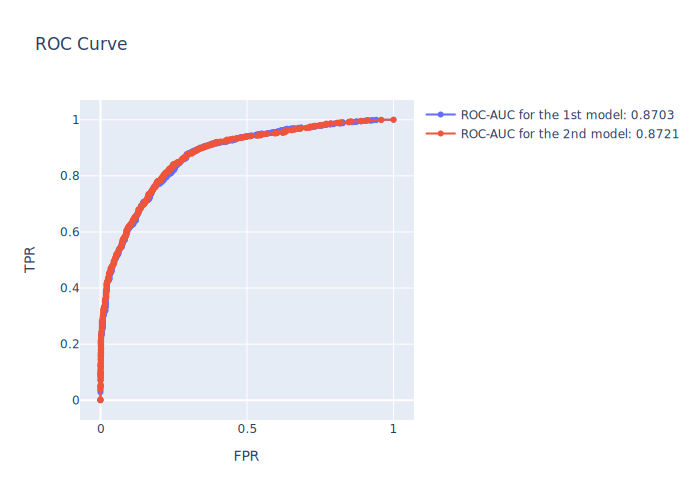

In [23]:
# ploting ROC
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr,
                    mode='lines+markers',
                    name=f'ROC-AUC for the 1st model: {round(first_model_auc.mean(),4)}'))
fig.add_trace(go.Scatter(x=fpr_2, y=tpr_2,
                    mode='lines+markers',
                    name=f'ROC-AUC for the 2nd model: {round(second_model_auc.mean(),4)}'))
fig.update_layout(
    title="ROC Curve",
    xaxis_title="FPR",
    yaxis_title="TPR",    
)
fig.show()


This is the famous ROC Curve as you can see the AUC (area under the ROC curve) goes from 0 to 1. But realistic goes to 0.5 to 1, because we can always construct a base model that it is line (you can look it up on the internet). So keep it mind that the closest to 1 the AUC value is, the better is the model. Values too near 0.5 are very bad, because they are predicting near to a complete randomness.